In [1]:
# script_hang indefinitely at points_to_convex_hull_volume_mask

import numpy as np
import stackview
from vedo import Points, ConvexHull, Volume


def points_to_convex_hull_volume_mask(points, volume_shape_zyx, dilation_radius=3) -> Volume:
    """
    Converts a set of 3D points to a binary volume mask of the inner part of the embryo using a convex hull.

    This function takes a set of 3D points and a volume shape, constructs a convex hull from the points,
    binarizes the convex hull into a volume mask, and then erodes/dilates the mask. 

    Args:
        points (numpy.ndarray): A numpy array of shape (N, 3) representing the 3D points in ZYX order.
        volume_shape_zyx (tuple): A tuple (z, y, x) representing the shape of the volume.
        dilation_radius (int): The radius of the dilation applied to the volume mask.  This expands the mask
            outwards, useful for ensuring complete coverage of the structure represented by the points.

    Returns:
        vedo.Volume: A vedo.Volume object representing the binary volume mask.  The mask has values of 255 inside
            the convex hull and 0 outside.
    """
    points_raw = points[:, [2, 1, 0]]
    pts = Points(points_raw)
    print("Creating convex hull from points")
    hull = ConvexHull(pts)

    vol_shape_xyz = volume_shape_zyx[::-1]
    print("Binarizing convex hull into volume mask")
    vol_mask = hull.binarize(values=(255,0),dims=vol_shape_xyz,spacing=[1,1,1], origin=(0,0,0))
    if dilation_radius > 0:
        print(f"Dilating with radius of {dilation_radius}")
        modified = vol_mask.clone().dilate(neighbours=(dilation_radius,dilation_radius,dilation_radius))
    else:
        erosion_radius = abs(dilation_radius)
        print(f"Eroding with erosion radius of {erosion_radius}")
        modified = vol_mask.clone().erode(neighbours=(erosion_radius,erosion_radius,erosion_radius))
    return modified

down_cropped = np.load("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/script_hang_at__points_to_convex_hull_volume_mask/down_cropped_tp_767.npy")
print(down_cropped.shape)
points = np.load("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/script_hang_at__points_to_convex_hull_volume_mask/tp_767_surface_points.npy") 
print(points[0,:,:])
# mod = points_to_convex_hull_volume_mask(points, volume_shape_zyx=down_cropped.shape, dilation_radius=3)

(146, 298, 621)
[ 1 22 46]


In [5]:
stackview.slice(down_cropped, continuous_update=True)

In [6]:
from wbns import substract_background

only_structures = substract_background(down_cropped, 4, 1)

In [7]:
stackview.slice(only_structures, continuous_update=True)

In [9]:
# Otsu is clearly failing hard, and whole image is 1 value

from skimage import filters
from scipy import ndimage as cpu_ndimage


substracted_bkg = only_structures
th = filters.threshold_otsu(substracted_bkg)
mask = substracted_bkg >= th

structuring_element = np.ones((3,3,3))
eroded_mask = cpu_ndimage.binary_erosion(mask, structure=structuring_element).astype(mask.dtype)  # Keep original datatype
# Zerroing out the border to remove artifacts that wbns generates
zero_y = int(eroded_mask.shape[1] * (1.15 - 1) / 2) 
zero_x = int(eroded_mask.shape[2] * (1.15 - 1) / 2)
eroded_mask[:,-zero_y:,:] = False
eroded_mask[:,:zero_y,:] = False
eroded_mask[:,:,-zero_x:] = False
eroded_mask[:,:,:zero_x] = False
stackview.slice(mask, continuous_update=True)

In [16]:
substracted_bkg = only_structures
th = filters.threshold_mean(substracted_bkg)
mask = substracted_bkg >= th
stackview.slice(mask, continuous_update=True)

In [2]:
points.shape

(23110952, 3)

In [17]:
import numpy as np
points_766 = np.load("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/script_hang_at__points_to_convex_hull_volume_mask/tp_766_surface_points.npy")
points_766.shape

(92905, 3)

In [19]:
from scipy.spatial import ConvexHull
import time 

start_time = time.perf_counter()
hull = ConvexHull(points)
end_time = time.perf_counter()

execution_time = end_time - start_time
print(f"Function execution time: {execution_time:.4f} seconds")


Function execution time: 3.1477 seconds


Pruning points in a surface mask

/home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/stackview/_static_view.py:101: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  h, _ = np.histogram(self.obj, bins=num_bins)


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
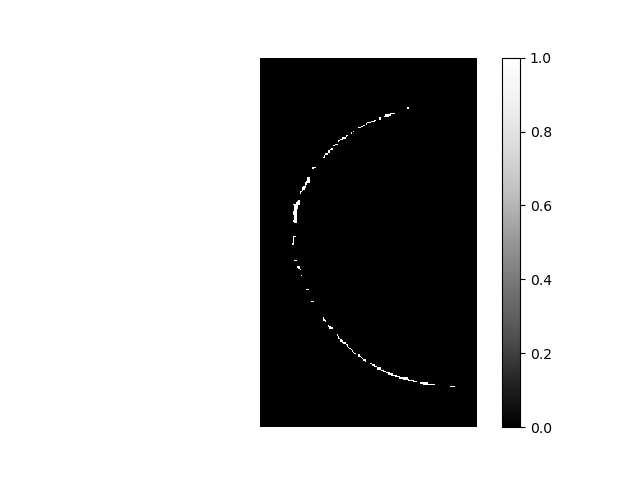
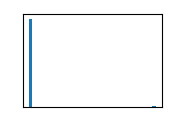

In [38]:
import tifffile as tiff
mask = tiff.imread("outs/tp_301_wbns_surface_voxels_true.tif")
mask = np.transpose(mask, (2,1,0))
stackview.insight(mask[244])

In [140]:
import numpy as np
from numba import njit, prange

@njit(parallel=True, cache=True)
def prune_volume_cpu(volume, block_h=4, block_w=4):
    """
    CPU accelerated pruning of voxels in a 3D volume using Numba.
    
    For each slice in the 3D boolean volume (shape: [n_slices, height, width]), the function:
      - Computes the mid-point of the slice as (x=width//2, y=height//2).
      - Splits the slice into non-overlapping 4x4 blocks by default.
      - Within each block, finds the True pixel furthest from the mid-point (using squared Euclidean distance).
      - Prunes the block by setting all True pixels to False except the selected one.
    
    Parameters:
        volume (np.ndarray): 3D numpy array with boolean values.
        block_h (int): Height of each block.
        block_w (int): Width of each block.
        
    Returns:
        volume (np.ndarray): The modified volume with pruned voxels.
    """
    n_slices, height, width = volume.shape
    block_h, block_w = 4, 4
    # mid-point for each slice (same for all slices)
    mid_y = height // 2
    mid_x = width // 2

    # Compute the number of blocks along each dimension.
    grid_y = (height + block_h - 1) // block_h
    grid_x = (width + block_w - 1) // block_w

    # Process each slice in parallel.
    for s in prange(n_slices):
        for by in range(grid_y):
            for bx in range(grid_x):
                start_y = by * block_h
                start_x = bx * block_w
                max_dist = -1.0
                max_r = -1
                max_c = -1
                # First pass: Find the True pixel with the maximum distance.
                for i in range(block_h):
                    r = start_y + i
                    if r >= height:
                        break
                    for j in range(block_w):
                        c = start_x + j
                        if c >= width:
                            break
                        if volume[s, r, c]:
                            dx = c - mid_x
                            dy = r - mid_y
                            dist = dx * dx + dy * dy
                            if dist > max_dist:
                                max_dist = dist
                                max_r = r
                                max_c = c
                # Second pass: Clear all True pixels except the one with max distance.
                if max_r != -1:  # if at least one True pixel was found
                    for i in range(block_h):
                        r = start_y + i
                        if r >= height:
                            break
                        for j in range(block_w):
                            c = start_x + j
                            if c >= width:
                                break
                            if volume[s, r, c] and not (r == max_r and c == max_c):
                                volume[s, r, c] = False
    return volume

if __name__ == '__main__':
    # Example usage: create a small random volume of shape (2, 8, 8)
    np.random.seed(0)
    volume = (np.random.rand(170, 2900, 635) > 0.9)
    print("Original volume:")
    # print(volume.astype(np.int32))
    
    # Create a copy if you wish to preserve the original volume.
    # pruned = prune_volume_cpu(volume.copy())
    print("Pruned volume:")
    # print(pruned.astype(np.int32))


Original volume:
Pruned volume:


In [137]:
volume = (np.random.rand(170, 2900, 635) > 0.9)

In [142]:
pruned = prune_volume_cpu(volume.copy())

In [116]:
stackview.slice(pruned, continuous_update=True, zoom_factor=2)